In [47]:
import pandas as pd
import numpy as np
from numpy import sin, sign, cos
import pickle
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt

from src.features import load_trips, remove_outliers
from src.models.PhysicalModel import PhysicalModel
from src.models.BehaviourTransformer import BehaviourTransformer


rc = {
    "font.sans-serif": ["Fira Sans Condensed", "Arial"],
    "lines.linewidth": 2.5,
    # "axes.grid": True,
    # "axes.grid.axis": "x",
    "grid.linewidth": 1.5,
    "axes.titleweight": "bold",
    "axes.titlelocation": "left",
    "legend.edgecolor": "none",
    "legend.fontsize": "small",
    "legend.title_fontsize": 0,
    "xtick.bottom": True,
    "axes.edgecolor": ".15",
    "figure.figsize": [8.0, 5.0],
    "axes.spines.bottom": True,
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.top": False,
}
sns.set_theme( 
    style="whitegrid",
    context="notebook",
    rc=rc
)

pd.set_option('display.max_columns', None)

In [2]:
df = load_trips(['M3_VH', 'CPH1_HH', 'CPH1_VH'], trips='all', sampling='2s')
df_test = load_trips(['CPH6_VH', 'CPH6_HH'], trips='all', sampling='2s')

outlier_columns = ['acceleration_z',
                   'acceleration_y',
                   'acceleration_x',
                   'steering_position',
                   'steering_acceleration',
                   'traction_instant_consumption',
                   'yaw_rate',
                   'velocity']

df = remove_outliers(df, outlier_columns)
df = df.sort_index()


# df_test = remove_outliers(df_test, outlier_columns)
# df_test = df_test.sort_index()

In [208]:
behaviour_transformer = BehaviourTransformer()

df_model = df.merge(behaviour_transformer.adjust_acceleration(df, columns=["acceleration_x", "acceleration_y"]), 
                    left_index=True, right_index=True)

df_model = df_model.reset_index().drop_duplicates('TS_or_Distance').set_index('TS_or_Distance')

behaviour_transformer.fit(df_model)

physical_model = PhysicalModel()
physical_model.fit("velocity", "acceleration_y")

In [209]:
df_model = df_model.merge(behaviour_transformer.transform(df_model), left_index=True, right_index=True)\
             .assign(kW_pred=physical_model.predict(df_model))\
             .assign(error=lambda x: x.kW_pred - x.traction_instant_consumption)

In [210]:
import lightgbm as lgb

features_road = ["traffic_lights", "road_signs", "speed_limit", "ped_walks", "speed_bumps", "bike_lane"]
features = ['adjusted_acceleration_x', 'adjusted_acceleration_y', 'yaw_rate', 'velocity'] + ['driver_safety_belt_reminder'] + behaviour_transformer.behavioural_columns + features_road + behaviour_transformer.var_cols
target = "error"

In [211]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit()

model = lgb.LGBMRegressor()
model.fit(df_model[features], df_model[target])

LGBMRegressor()

# Testing

In [223]:
df_test_old = df_test.copy()

In [224]:
df_test = df_test_old[~df_test_old.index.duplicated(keep='first')]
df_test.loc[:, features_road] = df_test[features_road].fillna(0)

df_test = df_test.dropna(how='any', axis=0)

In [225]:
df_model_test = df_test.merge(behaviour_transformer.adjust_acceleration(df_test, columns=["acceleration_x", "acceleration_y"]), 
                    left_index=True, right_index=True)

physical_model = PhysicalModel()
physical_model.fit("velocity", "acceleration_y")

In [226]:
df_model_test = df_model_test.merge(behaviour_transformer.transform(df_model_test), left_index=True, right_index=True)\
                            .assign(kW_pred=physical_model.predict(df_test))

In [227]:
df_model_test.trip.unique()

array([13201., 13175.])

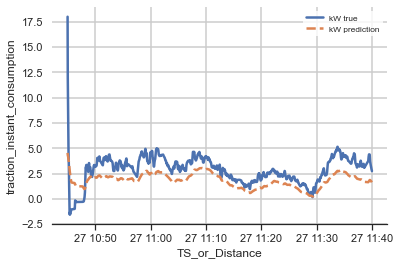

In [228]:
df_plot = df_model_test.query("`trip` == 13175").rolling("5min").mean().reset_index()

sns.lineplot(data=df_plot, x="TS_or_Distance", y="traction_instant_consumption", label='kW true')
sns.lineplot(data=df_plot, x="TS_or_Distance", y="kW_pred", label='kW prediction', linestyle='--')

plt.legend()

In [231]:
df_model['error_pred'] = model.predict(df_model[features])
df_model['kW_pred_final'] = df_model['kW_pred'] - df_model['error_pred']


df_model_test['error_pred'] = model.predict(df_model_test[features])
df_model_test['kW_pred_final'] = df_model_test['kW_pred'] - df_model_test['error_pred']


# df_model_test['kW_pred_final'] = model.predict(df_model_test[features])

In [236]:
from sklearn.metrics import r2_score

print(r2_score(df_model['traction_instant_consumption'], df_model['kW_pred_final']))
print(r2_score(df_model_test['traction_instant_consumption'], df_model_test['kW_pred_final']))

0.6096761006708544
-0.23501271820380287


In [251]:
df_model.trip.unique()

array([ 7448.,  7511.,  7505.,  7509.,  7792.,  7805.,  7895.,  7995.,
        8042.,  8040.,  8227.,  8197.,  9289., 10204., 10218., 10446.,
       10900., 11360., 11367.])

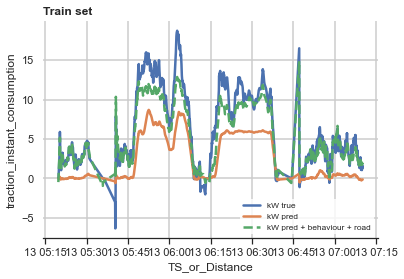

In [255]:
df_plot = df_model.query("`trip` == 7448").rolling("2min").mean().reset_index()

sns.lineplot(data=df_plot, x="TS_or_Distance", y="traction_instant_consumption", label='kW true')
sns.lineplot(data=df_plot, x="TS_or_Distance", y="kW_pred", label='kW pred')
sns.lineplot(data=df_plot, x="TS_or_Distance", y="kW_pred_final", label='kW pred + behaviour + road', linestyle='--')

plt.title('Train set')
plt.legend()

In [ ]:
df_model_test.trip.unique()

array([13201., 13175.])

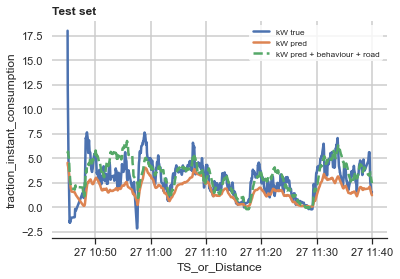

In [257]:
df_plot = df_model_test.query("`trip` == 13175").rolling("2min").mean().reset_index()

sns.lineplot(data=df_plot, x="TS_or_Distance", y="traction_instant_consumption", label='kW true')
sns.lineplot(data=df_plot, x="TS_or_Distance", y="kW_pred", label='kW pred')
sns.lineplot(data=df_plot, x="TS_or_Distance", y="kW_pred_final", label='kW pred + behaviour + road', linestyle='--')

plt.title('Test set')
plt.legend()

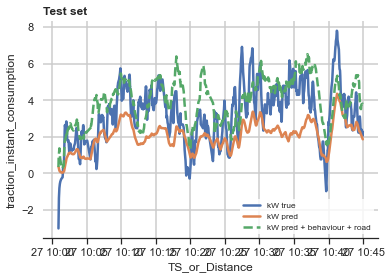

In [ ]:
df_plot = df_model_test.query("`trip` == 13201").rolling("2min").mean().reset_index()

sns.lineplot(data=df_plot, x="TS_or_Distance", y="traction_instant_consumption", label='kW true')
sns.lineplot(data=df_plot, x="TS_or_Distance", y="kW_pred", label='kW pred')
sns.lineplot(data=df_plot, x="TS_or_Distance", y="kW_pred_final", label='kW pred + behaviour + road', linestyle='--')

plt.title('Test set')
plt.legend()

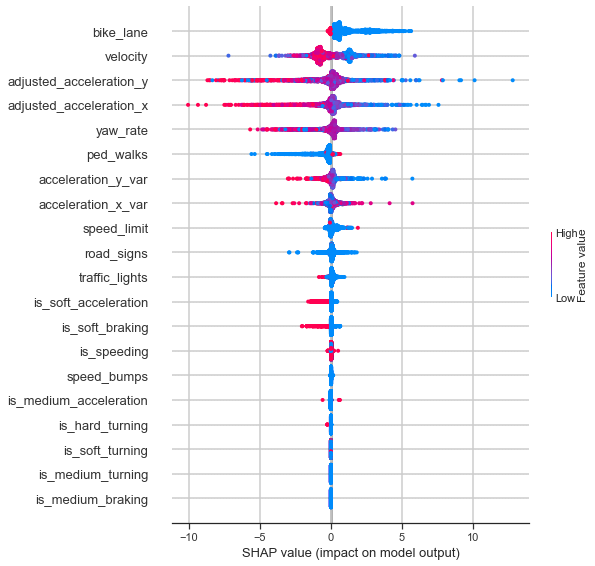

In [258]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_model_test[features])

shap.summary_plot(shap_values, df_model_test[features])